In [195]:
# hide
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from clientClass import Client
import torch
import random
from cryptotree.preprocessing import Featurizer
from cryptotree.tree import NeuralRandomForest, SigmoidTreeMaker, TanhTreeMaker
from cryptotree.polynomials import plot_graph_function_approximation
from cryptotree.cryptotree import HomomorphicNeuralRandomForest, HomomorphicTreeEvaluator, HomomorphicTreeFeaturizer
from cryptotree.polynomials import polyeval_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from fastai.basic_data import DataBunch
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy
from cryptotree.tree import CrossEntropyLabelSmoothing
from sklearn.ensemble import RandomForestClassifier
from dataFunction import import_data, new_df, data_prep, make_dummies
from torch.utils import data
from cryptotree.seal_helper import create_seal_globals, append_globals_to_builtins
import builtins
import tenseal.sealapi as seal
# nest_asyncio.apply()
# np.random.seed(10)
# tf.random.set_seed(10)
# tff.framework.set_default_context(tff.backends.native.create_thread_debugging_execution_context(clients_per_thread=50))


# Make Dataframes for every dataset

In [197]:

cleveland = "processed.cleveland.data"
switzerland = "processed.switzerland.data"
va = "processed.va.data"
hungarian = "reprocessed.hungarian.data"
cleveland_df, switzerland_df, va_df, hungarian_df = import_data(cleveland, switzerland, va, hungarian)
df = new_df(cleveland_df, switzerland_df, va_df, hungarian_df)

In [198]:
hungarian_df = df[df.Location == 'Hungarian'].drop(columns=['Location'])
switzerland_df = df[df.Location == 'Switzerland'].drop(columns=['Location'])
cleveland_df = df[df.Location == 'Cleveland'].drop(columns=['Location'])
va_df = df[df.Location == 'VA'].drop(columns=['Location'])

In [217]:
torch.random.manual_seed(73)
random.seed(73)
n_clients = 4
df_dict ={
    'Cleveland': cleveland_df,
    'Switzerland': switzerland_df,
    'VA Long Beach': va_df,
    'Hungary': hungarian_df        
    }
clients = []
for i in list(df_dict.keys()):
    location_data = df_dict.get(i)
    y = location_data.HeartDisease
    # y =  torch.tensor(location_data["HeartDisease"].values).float().unsqueeze(1)
    location_data = location_data.drop(columns="HeartDisease")
    cat_feat = ['ChestPainType', 'RestingECG', 'ST_Slope']
    location_data = make_dummies(location_data, cat_feat)
    numeric_feature_names = ['Age', 'MaxHR', 'RestingBP',  'Cholesterol', 'Oldpeak']
    location_data[numeric_feature_names] = (location_data[numeric_feature_names] - location_data[numeric_feature_names].mean()) / location_data[numeric_feature_names].std()
    x = location_data
    print(x.describe())
    print(i)
    # x = torch.tensor(location_data.values).float()
    clients.append(Client(i, x, y, cat_feat))

# clients[1].X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(clients[1].X, clients[1].y, test_size=0.2, random_state=42)

                Age         Sex     RestingBP   Cholesterol   FastingBS  \
count  3.030000e+02  303.000000  3.030000e+02  3.030000e+02  303.000000   
mean  -8.793846e-18    0.679868  4.160588e-16  1.700144e-16    0.148515   
std    1.000000e+00    0.467299  1.000000e+00  1.000000e+00    0.356198   
min   -2.814459e+00    0.000000 -2.141495e+00 -2.331021e+00    0.000000   
25%   -7.123780e-01    0.000000 -6.642009e-01 -6.893626e-01    0.000000   
50%    1.727088e-01    1.000000 -9.601098e-02 -1.099538e-01    0.000000   
75%    7.258879e-01    1.000000  4.721790e-01  5.467095e-01    0.000000   
max    2.496061e+00    1.000000  3.881319e+00  6.128347e+00    1.000000   

              MaxHR  ExerciseAngina       Oldpeak  ChestPainType_1.0  \
count  3.030000e+02      303.000000  3.030000e+02         303.000000   
mean  -1.443656e-16        0.326733 -1.003964e-16           0.075908   
std    1.000000e+00        0.469794  1.000000e+00           0.265288   
min   -3.436382e+00        0.000000 

In [212]:
for i in clients:
    

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_1.0,ChestPainType_4.0,ChestPainType_3.0,ChestPainType_2.0,RestingECG_0.0,RestingECG_1.0,RestingECG_2.0,ST_Slope_1.0,ST_Slope_2.0,ST_Slope_3.0
0,-2.583221,1.0,-1.567049,NaN,0.0,0.209513,0.0,0.050711,1,0,0,0,1,0,0,1,0,0
1,-2.360577,1.0,-0.676805,NaN,0.0,1.248877,0.0,-0.432630,0,1,0,0,1,0,0,1,0,0
2,-2.249255,1.0,-0.009121,NaN,0.0,0.324998,1.0,-0.142625,0,1,0,0,1,0,0,0,1,0
3,-2.137933,1.0,-0.899366,NaN,0.0,0.132524,1.0,0.340716,0,1,0,0,1,0,0,0,1,0
4,-1.915288,0.0,-1.121927,NaN,0.0,1.710816,0.0,2.080746,0,1,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,1.647020,1.0,-0.676805,NaN,0.0,-1.137810,1.0,-0.625967,0,1,0,0,0,1,0,0,1,0
119,1.647020,1.0,0.436001,NaN,1.0,1.364362,1.0,1.307399,0,1,0,0,1,0,0,0,1,0
120,1.869664,1.0,1.326245,NaN,0.0,-0.290921,0.0,0.920726,0,0,1,0,0,0,1,0,1,0
121,1.980987,0.0,1.326245,NaN,0.0,-0.021456,0.0,-0.625967,0,0,1,0,0,1,0,1,0,0


# Encryption methods
-   Homomorphic Encryption (HE)
-   Differential Privacy (DP)
-   Secure Multiparty Computations (SMPC)

# HE
- TenSEAL
- linear 


In [200]:
class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

In [201]:
X_train = X_train.fillna(0)

In [202]:
pipe = Featurizer(cat_feat)
X_train_normalized = pipe.fit_transform(X_train)

In [203]:
max_depth = 3

dilatation_factor = 10
polynomial_degree = dilatation_factor


In [204]:
sigmoid_tree_maker = SigmoidTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

tanh_tree_maker = TanhTreeMaker(use_polynomial=True,
                                  dilatation_factor=dilatation_factor, polynomial_degree=polynomial_degree)

In [205]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=7, random_state=0)
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(max_depth=7, random_state=0)

In [206]:
X_train_normalized, X_valid_normalized, y_train, y_valid = train_test_split(pipe.transform(X_train), 
                                                                            y_train,
                                                                            train_size=0.8)
y_train = y_train.astype(int)
y_valid = y_valid.astype(int)
train_ds = TabularDataset(X_train_normalized, y_train.values)
valid_ds = TabularDataset(X_valid_normalized, y_valid.values)



In [210]:
X_train.drop

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,ChestPainType_1.0,ChestPainType_4.0,ChestPainType_3.0,ChestPainType_2.0,RestingECG_0.0,RestingECG_1.0,RestingECG_2.0,ST_Slope_1.0,ST_Slope_2.0,ST_Slope_3.0
count,97.000000,97.000000,97.000000,97.0,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.00000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.033423,0.907216,0.062006,0.0,0.041237,0.017832,0.474227,0.001879,0.030928,0.793814,0.14433,0.030928,0.680412,0.257732,0.061856,0.247423,0.639175,0.113402
std,0.985023,0.291636,1.015109,0.0,0.199871,1.022443,0.501929,0.948603,0.174022,0.406667,0.35325,0.174022,0.468739,0.439658,0.242145,0.433756,0.482735,0.318731
min,-2.360577,0.000000,-1.567049,0.0,0.000000,-2.369648,0.000000,-2.075992,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.468100,1.000000,-0.676805,0.0,0.000000,-0.637375,0.000000,-0.625967,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.199832,1.000000,-0.009121,0.0,0.000000,0.017039,0.000000,-0.142625,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.756443,1.000000,0.658562,0.0,0.000000,0.825433,1.000000,0.630721,0.000000,1.000000,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,2.092309,1.000000,3.106733,0.0,1.000000,2.326735,1.000000,2.950761,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [208]:
bs = 128

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)
tree_maker = tanh_tree_maker



rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
rf.fit(X_train_normalized, y_train)

estimators = rf.estimators_
sigmoid_neural_rf = NeuralRandomForest(estimators, sigmoid_tree_maker)
tanh_neural_rf = NeuralRandomForest(estimators, tanh_tree_maker)

with torch.no_grad():
    sigmoid_neural_pred = sigmoid_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    tanh_neural_pred = tanh_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

pred = rf.predict(X_train_normalized)
print(f"Original accuracy : {(pred == y_train).mean()}")

print(f"Accuracy of sigmoid  : {(sigmoid_neural_pred == y_train).mean()}")
print(f"Accuracy of tanh : {(tanh_neural_pred == y_train).mean()}")

print(f"Match between sigmoid and original : {(sigmoid_neural_pred == pred).mean()}")
print(f"Match between tanh and original : {(tanh_neural_pred == pred).mean()}")



ValueError: need at least one array to stack

In [69]:
tree_maker = tanh_tree_maker
model = NeuralRandomForest(rf.estimators_, tree_maker=tree_maker)

model.freeze_layer("comparator")
model.freeze_layer("matcher")

for p in model.parameters():
    print(p.shape, p.requires_grad)

torch.Size([18, 55, 100]) False
torch.Size([55, 100]) False
torch.Size([56, 55, 100]) False
torch.Size([56, 100]) False
torch.Size([2, 56, 100]) True
torch.Size([2, 100]) True


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


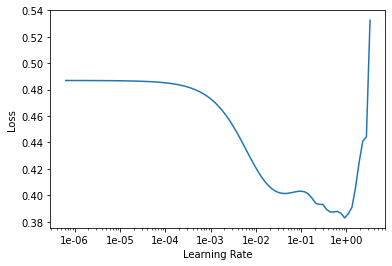

In [218]:
data = DataBunch(train_dl, valid_dl,fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, model, loss_func=criterion, metrics=accuracy)
learn.lr_find()
learn.recorder.plot()

In [72]:
learn.fit_one_cycle(5,1e-1/2)

epoch,train_loss,valid_loss,accuracy,time
0,0.658476,0.718581,0.459016,00:00
1,0.638974,0.621392,0.688525,00:00
2,0.622615,0.707079,0.540984,00:00
3,0.605993,0.604869,0.688525,00:00
4,0.584027,0.572073,0.721311,00:00


In [73]:
pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 1.0
Accuracy : 0.8057851239669421
Same output : 0.8057851239669421


In [74]:
dilatation_factor = 16
degree = dilatation_factor

PRECISION_BITS = 28
UPPER_BITS = 9

polynomial_multiplications = int(np.ceil(np.log2(degree))) + 1
n_polynomials = 2
matrix_multiplications = 3

depth = matrix_multiplications + polynomial_multiplications * n_polynomials

poly_modulus_degree = 16384

moduli = [PRECISION_BITS + UPPER_BITS] + (depth) * [PRECISION_BITS] + [PRECISION_BITS + UPPER_BITS]
print(moduli)
print(sum(moduli))

[37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 37]
438


In [43]:
create_seal_globals(globals(), poly_modulus_degree, moduli, PRECISION_BITS, use_symmetric_key=False)
append_globals_to_builtins(globals(), builtins)

In [44]:
h_rf = HomomorphicNeuralRandomForest(model)

tree_evaluator = HomomorphicTreeEvaluator.from_model(h_rf, tree_maker.coeffs, 
                                                   polyeval_tree, evaluator, encoder, relin_keys, galois_keys, 
                                                   scale)

homomorphic_featurizer = HomomorphicTreeFeaturizer(h_rf.return_comparator(), encoder, encryptor, scale)

In [45]:
i = 0

x = X_train_normalized[i]
ctx = homomorphic_featurizer.encrypt(x)

outputs = tree_evaluator(ctx)

In [46]:
ptx = seal.Plaintext()
decryptor.decrypt(outputs, ptx)

homomorphic_pred = encoder.decode_double(ptx)[:2]

In [47]:
x = X_train_normalized[i]

pred = rf.predict_proba(x.reshape(1,-1))
neural_pred = model(torch.tensor(x).float().unsqueeze(0))

print(f"Original Random Forest output : {pred}")
print(f"Neural Random Forest output : {neural_pred.detach()}")
print(f"Homomorphic Random Forest output : {homomorphic_pred}")

Original Random Forest output : [[0.615485 0.384515]]
Neural Random Forest output : tensor([[ 0.3894, -0.0193]])
Homomorphic Random Forest output : [0.41237472196418046, -0.015424882056061889]


In [48]:
from fastai.core import parallel
import multiprocessing
import tenseal.sealapi as seal

def predict(x):
    """Performs HRF prediction"""
    
    # We first encrypt and evaluate our model on it
    ctx = homomorphic_featurizer.encrypt(x)
    outputs = tree_evaluator(ctx)
    
    # We then decrypt it and get the first 2 values which are the classes scores
    ptx = seal.Plaintext()
    decryptor.decrypt(outputs, ptx)
    
    homomorphic_pred = encoder.decode_double(ptx)[:2]
    homomorphic_pred = np.argmax(homomorphic_pred)
    
    return homomorphic_pred


# # We get the number of cores
# cores = multiprocessing.cpu_count()

# # We compute the outputs
# hrf_pred = parallel(predict, X_valid_normalized, max_workers=cores)

# # Because the outputs are unordered we must first sort by index then take the predictions
# hrf_pred = np.array(sorted(hrf_pred, key = lambda x:x[0]))[:,1]

# hrf_pred = predict(X_valid_normalized,1)

In [49]:
hrf_pred = []
for i in X_valid_normalized:
    # print(i)
    hrf_pred.append(predict(i))

In [50]:
outputs = []

for x,y in valid_dl:
    with torch.no_grad():
        pred = model(x)
    outputs.append(pred)
    
nrf_pred = torch.cat(outputs).argmax(dim=1).numpy()

In [51]:
linear = LogisticRegression()
linear.fit(X_train_normalized, y_train)

# We compute the linear preds
linear_pred = linear.predict(X_valid_normalized)

# We compute the random forest predictions
rf_pred = rf.predict(X_valid_normalized)

In [52]:
def compute_metrics(pred, y):
    """Computes all the metrics between predictions and real values"""
    accuracy = accuracy_score(pred,y)
    precision = precision_score(pred,y)
    recall = recall_score(pred,y)
    f1 = f1_score(pred, y)
    return dict(accuracy=accuracy, precision=precision, recall=recall, f1=f1)

models = dict(nrf=nrf_pred,hrf=hrf_pred, rf=rf_pred, linear=linear_pred)

outputs = []
for name, pred in models.items():
    metrics = compute_metrics(pred, y_valid)
    metrics["model"] = name
    outputs.append(metrics)

In [53]:
outputs = pd.DataFrame(outputs)

In [54]:
outputs

,accuracy,precision,recall,f1,model
0,0.803279,0.653846,0.850000,0.739130,nrf
1,0.803279,0.653846,0.850000,0.739130,hrf
2,0.836066,0.769231,0.833333,0.800000,rf
3,0.852459,0.807692,0.840000,0.823529,linear
